### Nov 2018
### MJP
# Want to experiment with use of scipy's optimization functions:
 -  scipy.optimize.least_squares / scipy.optimize.minimize / scipy.optimize.curve_fit
### Purpose is to understand how to use them as a (temporary?) part of developing a robust fitting routine for use in the MPC's NBody code

In [11]:
%matplotlib inline
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Least-squares seems to be the "lowest-level" function
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
 - "Given the residuals f(x) (an m-dimensional real function of n real variables) and the loss function rho(s) (a scalar function), least_squares finds a local minimum of the cost function F(x): ..."
 

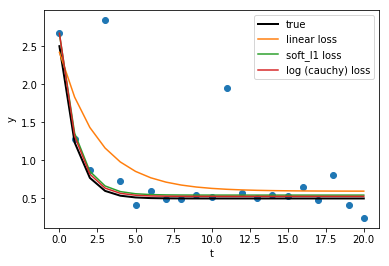

In [20]:
# Follow ingedients in https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares

# Basic model form 
def modelFunc(x,t):
    return x[0] + x[1] * np.exp(x[2] * t)

# Make data according to model, but add noise
def synthesizeData(x,t, noise=0.1, n_outliers=3 , random_state=0):
    y = modelFunc(x,t)
    rnd = np.random.RandomState(random_state)
    error = noise * rnd.randn(t.size)
    outliers = rnd.randint(0, t.size, n_outliers) 
    error[outliers] *= 10
    return y + error
x_True = np.array([0.5,2.0,-1.0])
t_Data = np.arange(0,21,1)
y_Data = synthesizeData(x_True, t_Data)

# Define function for computing residuals  
def resFunc(x, t, y):
    return modelFunc(x,t) - y
    #return x[0] + x[1] * np.exp(x[2] * t) - y
    
# initial estimate of parameters.
x0 = np.array([1.0, 1.0, 0.0])

# L.S.Fit
res_lsq = least_squares(resFunc, x0, args=(t_Data, y_Data))

# L.S. Fit with differing loss-functions 
# Now compute two solutions with two different robust loss functions. The parameter f_scale is set to 0.1, meaning that inlier residuals should not significantly exceed 0.1 (the noise level used).
res_soft_l1 = least_squares(resFunc, x0, loss='soft_l1', f_scale=0.1, args=(t_Data, y_Data))
res_log     = least_squares(resFunc, x0, loss='cauchy',  f_scale=0.1, args=(t_Data, y_Data))

# Plot results 
y_true = modelFunc(x_True,     t_Data)
y_lsq  = modelFunc(res_lsq.x, t_Data )
y_soft_l1 = modelFunc(res_soft_l1.x, t_Data)
y_log     = modelFunc(res_log.x, t_Data)

plt.plot(t_Data, y_Data, 'o')
plt.plot(t_Data, y_true, 'k', linewidth=2, label='true')
plt.plot(t_Data, y_lsq,       label='linear loss')
plt.plot(t_Data, y_soft_l1  , label='soft_l1 loss ')
plt.plot(t_Data, y_log,       label='log (cauchy) loss')

plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

### Here I experiment with an analytic function & its jacobian  

In [3]:
#https://www.reddit.com/r/learnpython/comments/6tcy6m/how_to_input_jacobian_function_in/
    
def func(t, K, zeta, omega_n, omega_d, phi):
    return  K*np.exp(-zeta*omega_n*t)*np.cos(omega_d*t - phi)
def jacobian(t, K, zeta, omega_n, omega_d, phi):
    dK     =np.exp(-omega_n*t*zeta)*np.cos(omega_d*t - phi)
    dzeta  =-K*omega_n*t*np.exp(-omega_n*t*zeta)*np.cos(omega_d*t - phi)
    domegan=-K*t*zeta*np.exp(-omega_n*t*zeta)*np.cos(omega_d*t - phi)
    domegad=-K*t*np.exp(-omega_n*t*zeta)*np.sin(omega_d*t - phi)   # stemmer med mathcad
    dphi   =K*np.exp(-omega_n*t*zeta)*np.sin(omega_d*t - phi) 
    return np.transpose([dK,dzeta,domegan,domegad,dphi])

opt.curve_fit(func, Time, Data1,jac=jacobian)
